In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt 

In [3]:

import sys
sys.path.append('../')
import pandas as pd 
import numpy as np 

import datetime
from src.utils.io.read import RawDataReader
from src.settings import Settings
from src.utils.dates import get_nyse_business_dates
from src.utils.dates import count_business_days_series

In [4]:
from src.preprocessing.index_roll_dates import get_index_roll_dates 

In [5]:
wti_prices_panel = pd.read_csv(Settings.backfill.paths.PREPROCESSED_DATA_PATH / 'wti_prices_panel.csv')

In [6]:
wti_prices_panel['tradeDate'] = pd.to_datetime(wti_prices_panel['tradeDate'], errors='coerce').dt.date

In [7]:
business_dates = get_nyse_business_dates(wti_prices_panel['tradeDate'].min(),
                        wti_prices_panel['tradeDate'].max())

In [8]:
dataset = wti_prices_panel[wti_prices_panel['tradeDate'].isin(business_dates)]

In [9]:
dataset[[ 'tradeDate',
         'F1_RolledPrice',
         'F2_RolledPrice',
        'F1MinusF2_RolledPrice' ]]

,tradeDate,F1_RolledPrice,F2_RolledPrice,F1MinusF2_RolledPrice
0,2010-01-04,105.35,87.74,17.61
1,2010-01-05,105.61,88.03,17.58
2,2010-01-06,107.02,89.37,17.65
3,2010-01-07,106.50,88.81,17.69
4,2010-01-08,106.59,88.92,17.67
...,...,...,...,...
3896,2025-06-30,65.11,63.85,1.26
3897,2025-07-01,65.45,64.15,1.30
3898,2025-07-02,67.45,66.01,1.44
3899,2025-07-03,67.00,65.62,1.38


In [10]:
import pandas as pd
import numpy as np
import  statsmodels.api as sm #import OLS, add_constant

def compute_rolling_beta(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute rolling OLS beta of F1_RolledPrice on F2_RolledPrice using 10- and 20-day windows.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns ['tradeDate', 'F1_RolledPrice', 'F2_RolledPrice']

    Returns:
        pd.DataFrame: DataFrame with new columns ['beta_10', 'beta_20']
    """
    df = df.copy()
    df = df.sort_values('tradeDate')
    
    def rolling_beta(x:pd.Series, y:pd.Series, window:int):
        betas = []
        for i in range(len(x)):
            if i < window:
                betas.append(np.nan)
            else:
                y_window = y[i-window:i]
                x_window = x[i-window:i]
                X = sm.add_constant(x_window)
                model = sm.OLS(y_window, X).fit()
                betas.append(model.params[1])
        return pd.Series(betas, index=df.index)
    
    df['beta_10'] = rolling_beta(df['F2_RolledPrice'], df['F1_RolledPrice'], window=10)
    df['beta_20'] = rolling_beta(df['F2_RolledPrice'], df['F1_RolledPrice'], window=20)
    
    return df


In [11]:
result_df = compute_rolling_beta(dataset)


In [12]:
result_df['SyntheticF1MinusF2_RolledPrice_change_10'] = result_df['F1_RolledPrice'] -  result_df['beta_10']* result_df['F2_RolledPrice'] 
result_df['SyntheticF1MinusF2_RolledPrice_change_20'] = result_df['F1_RolledPrice'] -  result_df['beta_20']* result_df['F2_RolledPrice'] 


In [13]:
result_df['F1MinusF2_RolledPrice'].describe()

count    3900.000000
mean       10.401667
std         5.502617
min        -0.550000
25%         6.947500
50%        12.055000
75%        14.232500
max        18.350000
Name: F1MinusF2_RolledPrice, dtype: float64

Text(0, 0.5, 'F1MinusF2_RolledPrice')

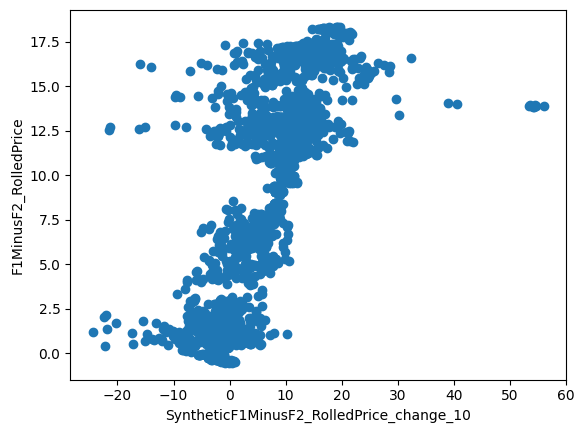

In [14]:
plt.plot(result_df['SyntheticF1MinusF2_RolledPrice_change_10'],
         result_df['F1MinusF2_RolledPrice'],
         'o')
plt.xlabel('SyntheticF1MinusF2_RolledPrice_change_10')
plt.ylabel('F1MinusF2_RolledPrice')

Text(0, 0.5, 'F1MinusF2_RolledPrice')

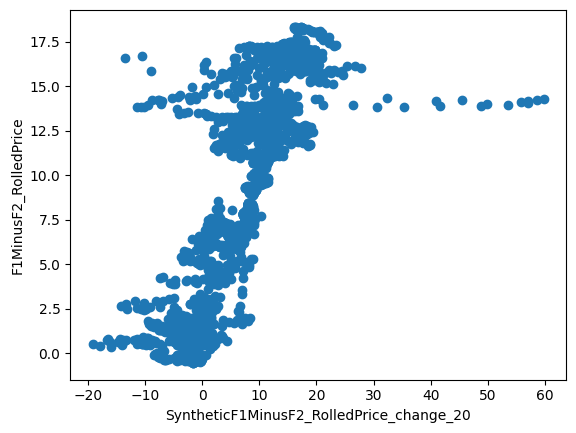

In [15]:
plt.plot(result_df['SyntheticF1MinusF2_RolledPrice_change_20'],
         result_df['F1MinusF2_RolledPrice'],
         'o')
plt.xlabel('SyntheticF1MinusF2_RolledPrice_change_20')
plt.ylabel('F1MinusF2_RolledPrice')

In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

def compute_rolling_pca_beta(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute rolling PCA hedge ratio (beta) of F1_RolledPrice and F2_RolledPrice
    using 10- and 20-day windows.

    Parameters:
        df (pd.DataFrame): DataFrame with ['tradeDate', 'F1_RolledPrice', 'F2_RolledPrice']

    Returns:
        pd.DataFrame: Original DataFrame with new columns ['pca_beta_10', 'pca_beta_20']
    """
    df = df.copy()
    df = df.sort_values('tradeDate')

    def rolling_pca_beta(f1, f2, window):
        betas = []
        for i in range(len(f1)):
            if i < window:
                betas.append(np.nan)
            else:
                window_data = np.column_stack((f1[i - window:i], f2[i - window:i]))
                pca = PCA(n_components=1)
                pca.fit(window_data)
                pc1 = pca.components_[0]
                # Avoid divide-by-zero
                if np.abs(pc1[1]) > 1e-6:
                    beta = pc1[0] / pc1[1]
                else:
                    beta = np.nan
                betas.append(beta)
        return pd.Series(betas, index=df.index)

    df['pca_beta_10'] = rolling_pca_beta(df['F1_RolledPrice'], df['F2_RolledPrice'], 10)
    df['pca_beta_20'] = rolling_pca_beta(df['F1_RolledPrice'], df['F2_RolledPrice'], 20)

    return df


In [17]:
result_df = compute_rolling_pca_beta(result_df)


In [18]:
result_df['SyntheticF1MinusF2_RolledPrice_change_pca_10'] = result_df['F1_RolledPrice'] -  result_df['pca_beta_10']* result_df['F2_RolledPrice'] 
result_df['SyntheticF1MinusF2_RolledPrice_change_pca_20'] = result_df['F1_RolledPrice'] -  result_df['pca_beta_20']* result_df['F2_RolledPrice'] 


Text(0, 0.5, 'beta_10')

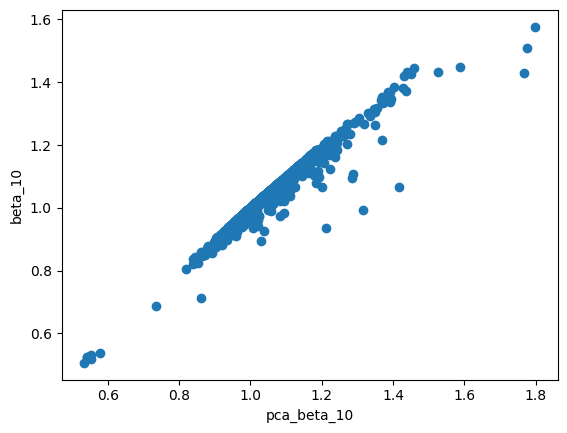

In [19]:
plt.plot(result_df['pca_beta_10'],
         result_df['beta_10'],
         'o')
plt.xlabel('pca_beta_10')
plt.ylabel('beta_10')

Text(0, 0.5, 'beta_20')

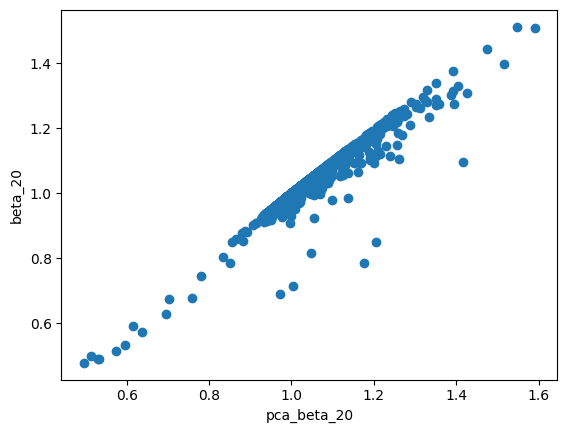

In [20]:
plt.plot(result_df['pca_beta_20'],
         result_df['beta_20'],
         'o')
plt.xlabel('pca_beta_20')
plt.ylabel('beta_20')

Text(0, 0.5, 'F1MinusF2_RolledPrice')

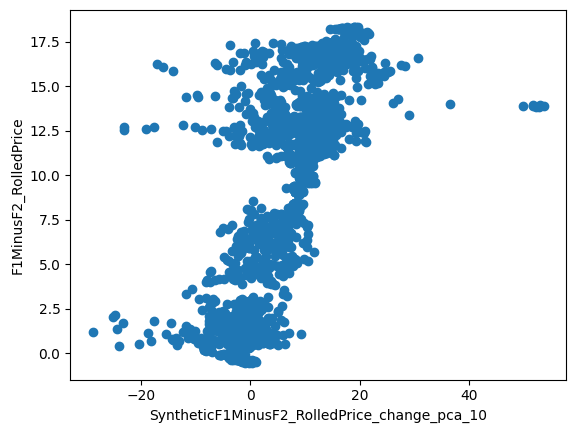

In [21]:
plt.plot(result_df['SyntheticF1MinusF2_RolledPrice_change_pca_10'],
         result_df['F1MinusF2_RolledPrice'],
         'o')
plt.xlabel('SyntheticF1MinusF2_RolledPrice_change_pca_10')
plt.ylabel('F1MinusF2_RolledPrice')

Text(0, 0.5, 'F1MinusF2_RolledPrice')

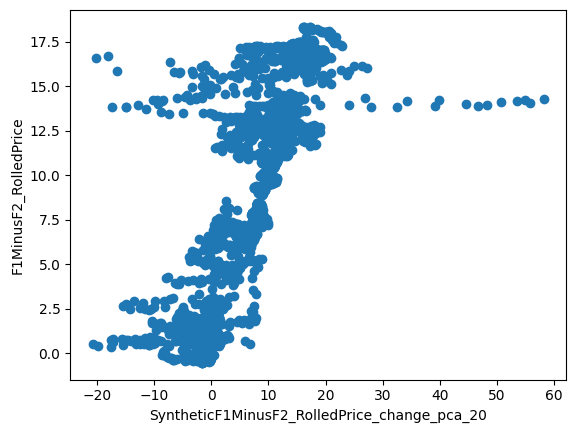

In [22]:
plt.plot(result_df['SyntheticF1MinusF2_RolledPrice_change_pca_20'],
         result_df['F1MinusF2_RolledPrice'],
         'o')
plt.xlabel('SyntheticF1MinusF2_RolledPrice_change_pca_20')
plt.ylabel('F1MinusF2_RolledPrice')